In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare, chi2_contingency
from itertools import combinations

# Load the dataset
df = pd.read_csv(
    "survey_responses-export-2025-11-18_11-43-08.csv",
    sep=";"
)

# Ensure the columns are integers
df["content_option_1"] = df["content_option_1"].astype(int)
df["content_option_2"] = df["content_option_2"].astype(int)
df["selected_option"] = df["selected_option"].astype(int)

print(f"Total responses loaded: {len(df)}")
df.head()

Total responses loaded: 254


,id,session_id,organism_taxid,organism_name,selected_option,comparison_number,created_at,content_option_1,content_option_2
0,edaed81f-0de8-4bcb-ae9c-ac42f9b92bbc,7ba368a4-7057-4785-a221-cd3d700f7656,3052230,Hepacivirus hominis,2,4,2025-11-07 15:19:58.99356+00,1,4
1,5bc3c899-b9c1-4e7b-8fa0-f571a6c4c80d,7ba368a4-7057-4785-a221-cd3d700f7656,3052608,Pegivirus hominis,1,7,2025-11-07 15:20:00.030615+00,2,3
2,d8ac614f-cdb7-46d6-84ef-58b6880acb78,7ba368a4-7057-4785-a221-cd3d700f7656,2697049,Severe acute respiratory syndrome coronavirus 2,2,13,2025-11-07 15:20:01.052836+00,1,3
3,8c94778f-015a-4526-852e-f86af0236628,7ba368a4-7057-4785-a221-cd3d700f7656,3046277,Orthoflavivirus flavi,1,12,2025-11-07 15:20:02.647136+00,2,3
4,33402367-9059-4a7c-91f8-5f653022a073,7ba368a4-7057-4785-a221-cd3d700f7656,3046277,Orthoflavivirus flavi,2,11,2025-11-07 15:20:04.015248+00,1,3


This step fixes the previous logic error. We calculate which prompt actually won each specific encounter.

In [2]:
# Create a 'winning_prompt' column based on user selection
# If selected_option is 1, the winner is the prompt in content_option_1
# If selected_option is 2, the winner is the prompt in content_option_2
df['winning_prompt'] = np.where(
    df['selected_option'] == 1, 
    df['content_option_1'], 
    df['content_option_2']
)

# Optional: Check for 'Position Bias' (Do users just blindly click Option 1?)
# If this is roughly 50%, there is no bias. If it's 80%, users prefer the left/top option regardless of content.
pos_1_win_rate = (df['selected_option'] == 1).mean()
print(f"Selection Rate for Position 1 (Left/Top): {pos_1_win_rate:.2%}")

Selection Rate for Position 1 (Left/Top): 49.61%


Since prompts might not have been shown an equal number of times, we must normalize the wins by the number of exposures (Total Appearances).

In [3]:
all_prompts = [1, 2, 3, 4]

# 1. Count Total Wins per prompt
win_counts = df['winning_prompt'].value_counts().reindex(all_prompts, fill_value=0)

# 2. Count Total Exposures (How many times was each prompt shown?)
appearances_1 = df['content_option_1'].value_counts().reindex(all_prompts, fill_value=0)
appearances_2 = df['content_option_2'].value_counts().reindex(all_prompts, fill_value=0)
total_appearances = appearances_1 + appearances_2

# 3. Calculate Win Rate
win_rates = (win_counts / total_appearances) * 100

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Wins': win_counts,
    'Exposures': total_appearances,
    'Win_Rate_PCT': win_rates
})

print("Summary of Performance:")
display(summary_df.sort_values('Win_Rate_PCT', ascending=False))

Summary of Performance:


,Wins,Exposures,Win_Rate_PCT
4,54,94,57.446809
1,78,153,50.980392
2,61,125,48.800000
3,61,136,44.852941


We visualize the Win Rate percentage, which is the fair metric to compare.

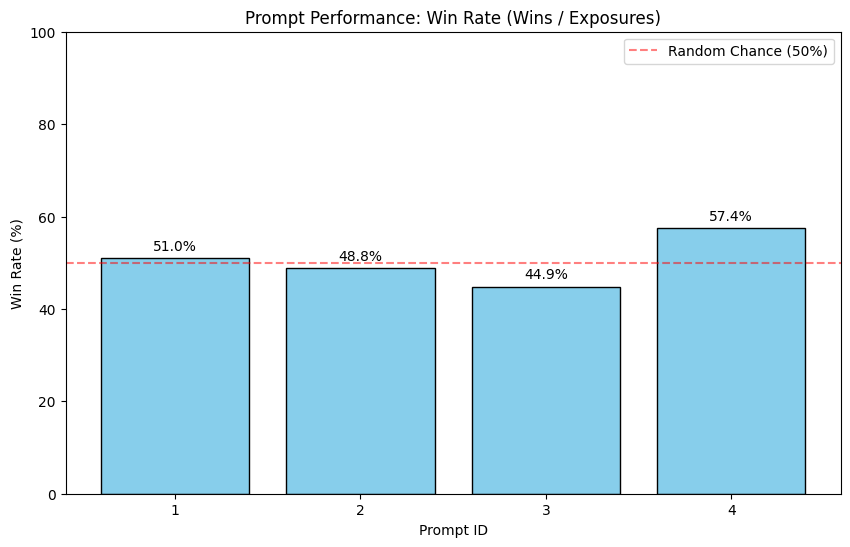

In [4]:
plt.figure(figsize=(10, 6))

# Plotting the Win Rate
bars = plt.bar(
    summary_df.index.astype(str), 
    summary_df['Win_Rate_PCT'], 
    color='skyblue', 
    edgecolor='black'
)

plt.xlabel("Prompt ID")
plt.ylabel("Win Rate (%)")
plt.title("Prompt Performance: Win Rate (Wins / Exposures)")
plt.ylim(0, 100)
plt.axhline(50, color='red', linestyle='--', alpha=0.5, label='Random Chance (50%)')
plt.legend()

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height + 1, 
        f'{height:.1f}%', 
        ha='center', 
        va='bottom'
    )

plt.show()

We test if the observed win counts deviate significantly from what we would expect by random chance (50% win rate).

In [5]:
# Null Hypothesis: Each prompt wins 50% of the time it is shown.
# Expected Wins = Total Exposures * 0.5
expected_wins = summary_df['Exposures'] * 0.5

# Chi-Square Goodness of Fit
chi2_stat, p_value = chisquare(f_obs=summary_df['Wins'], f_exp=expected_wins)

print("=== Global Chi-Square Test Results ===")
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_value:.4e}")

if p_value < 0.05:
    print("Conclusion: The difference in prompt performance is STATISTICALLY SIGNIFICANT.")
else:
    print("Conclusion: No statistically significant difference found between prompts.")

=== Global Chi-Square Test Results ===
Chi-Square Statistic: 1.8286
P-Value: 6.0874e-01
Conclusion: No statistically significant difference found between prompts.


This isolates specific matchups (e.g., Prompt 1 vs Prompt 2) to see if one beats the other directly.

In [6]:
pairwise_results = []

print("=== Pairwise Head-to-Head Analysis ===")

for p_a, p_b in combinations(all_prompts, 2):
    # Filter for rows where the comparison was specifically A vs B
    # (Check both orders: A vs B AND B vs A)
    matchup_mask = (
        ((df['content_option_1'] == p_a) & (df['content_option_2'] == p_b)) |
        ((df['content_option_1'] == p_b) & (df['content_option_2'] == p_a))
    )
    
    subset = df[matchup_mask]
    total_battles = len(subset)
    
    if total_battles == 0:
        continue
        
    wins_a = (subset['winning_prompt'] == p_a).sum()
    wins_b = (subset['winning_prompt'] == p_b).sum()
    
    # Chi-Square test for this specific pair (Expected: 50/50 split)
    # We use [wins_a, wins_b] vs [total/2, total/2]
    chi2, p, _, _ = chi2_contingency([[wins_a, wins_b], [total_battles/2, total_battles/2]])
    
    # Determine the winner label
    winner = p_a if wins_a > wins_b else p_b
    if wins_a == wins_b: winner = "Tie"
    
    pairwise_results.append({
        "Prompt A": p_a,
        "Prompt B": p_b,
        "Wins A": wins_a,
        "Wins B": wins_b,
        "Total Matches": total_battles,
        "Win Rate A": (wins_a / total_battles),
        "P-Value": p,
        "Significant (0.05)": p < 0.05
    })

# Convert to DataFrame for display
pairwise_df = pd.DataFrame(pairwise_results)
display(pairwise_df)

=== Pairwise Head-to-Head Analysis ===


,Prompt A,Prompt B,Wins A,Wins B,Total Matches,Win Rate A,P-Value,Significant (0.05)
0,1,2,31,29,60,0.516667,1.000000,False
1,1,3,34,25,59,0.576271,0.518095,False
2,1,4,13,21,34,0.382353,0.463744,False
3,2,3,21,20,41,0.512195,1.000000,False
4,2,4,11,13,24,0.458333,1.000000,False
5,3,4,16,20,36,0.444444,0.813381,False


Advanced analysis

1. The Bradley-Terry Model (Strength Ranking)Standard pairwise Chi-Square tests treat every matchup (e.g., Prompt 1 vs. 2) in isolation. This loses information about transitivity. If Prompt 1 beats 2, and 2 beats 3, we can infer 1 > 3 even if they never met or if the sample size for 1 vs. 3 is small.The Bradley-Terry model is a probabilistic model for paired comparisons (common in competitive assays or sports rankings). It estimates a latent "strength" parameter $\beta_i$ for each prompt such that:$$P(i > j) = \frac{e^{\beta_i}}{e^{\beta_i} + e^{\beta_j}}$$This aggregates all data into a single global ranking, increasing statistical power.2. "Probability of Being the Best" (Bayesian Bootstrap)In industry (and increasingly in genomics), we often care less about "Is $A \neq B$ with $p<0.05$?" and more about "What is the probability that $A$ is the best option?"Even if the p-value is 0.20, Prompt 1 might have a 85% probability of being the best. This is a risk-based decision: if the cost of switching prompts is low, betting on the 85% probability is rational even without statistical significance. We can estimate this using a Bootstrap approach.3. Power Analysis (Post-hoc)It is possible your effect size (the true difference in quality) is real but small (e.g., 52% vs 48%), and your sample size ($N$) was insufficient to detect it. A power analysis will tell you: "Given the variance we saw, we would need $N=1000$ to detect a difference." This prevents you from discarding a good prompt just because the study was underpowered.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.utils import resample

# --- 1. Data Prep (Ensure 'winner' column exists) ---
# Re-run this if you haven't defined 'winning_prompt' yet
if 'winning_prompt' not in df.columns:
    df['winning_prompt'] = np.where(
        df['selected_option'] == 1, 
        df['content_option_1'], 
        df['content_option_2']
    )

# --- 2. Bradley-Terry Model ---
def fit_bradley_terry(df):
    prompts = sorted(list(set(df['content_option_1']) | set(df['content_option_2'])))
    p_map = {p: i for i, p in enumerate(prompts)}
    n_prompts = len(prompts)
    
    # Extract pairs (Winner Index, Loser Index)
    # We define loser as the option that wasn't selected
    df['losing_prompt'] = np.where(df['selected_option'] == 1, df['content_option_2'], df['content_option_1'])
    pairs = df[['winning_prompt', 'losing_prompt']].values
    pairs_idx = [(p_map[w], p_map[l]) for w, l in pairs]

    # Negative Log Likelihood function
    # P(i beats j) = exp(beta_i) / (exp(beta_i) + exp(beta_j))
    def neg_log_likelihood(betas):
        nll = 0
        for w, l in pairs_idx:
            # We fix beta[0] = 0 for identifiability, so we append 0 to the optimization params
            b = np.concatenate(([0], betas)) 
            nll -= (b[w] - np.log(np.exp(b[w]) + np.exp(b[l])))
        return nll

    # Optimize (find betas for prompts 2, 3, 4... relative to 1)
    # We ignore the first prompt (reference) in optimization to avoid infinite solutions
    initial_guess = np.zeros(n_prompts - 1)
    res = minimize(neg_log_likelihood, initial_guess, method='BFGS')
    
    # Reconstruct full betas (Prompt 1 is 0.0)
    betas = np.concatenate(([0], res.x))
    
    # Convert Log-Odds (Beta) to "Probability vs Reference"
    # P(Win vs Ref) = exp(beta) / (exp(beta) + 1)
    probs_vs_ref = np.exp(betas) / (np.exp(betas) + 1)
    
    return pd.DataFrame({
        'Prompt': prompts,
        'BT_Strength_Score': betas,
        'Prob_Beat_Prompt_1': probs_vs_ref
    }).sort_values('BT_Strength_Score', ascending=False)

# --- 3. Bootstrap "Probability of Best" ---
def bootstrap_probability_best(df, n_iter=1000):
    wins_count = {p: 0 for p in [1, 2, 3, 4]}
    
    print(f"Running {n_iter} bootstrap simulations...")
    for i in range(n_iter):
        # Resample the DATA (rows), not just the stats
        sample = resample(df)
        
        # Simple win rate calculation for this sample
        # (You could run full BT model here but it's slow, simple win rate is a good proxy for 'best')
        win_counts = sample['winning_prompt'].value_counts()
        exposures = sample['content_option_1'].value_counts().add(sample['content_option_2'].value_counts(), fill_value=0)
        rates = win_counts / exposures
        
        # Who won this simulation?
        best_prompt = rates.idxmax()
        wins_count[best_prompt] += 1
        
    probs = pd.DataFrame(list(wins_count.items()), columns=['Prompt', 'N_Simulations_Won'])
    probs['Probability_of_Being_Best'] = probs['N_Simulations_Won'] / n_iter
    return probs.sort_values('Probability_of_Being_Best', ascending=False)

# --- Execute ---
bt_results = fit_bradley_terry(df)
print("\n=== Bradley-Terry Strength Scores (Global Ranking) ===")
display(bt_results)

prob_best_results = bootstrap_probability_best(df)
print("\n=== Bayesian/Bootstrap: Which prompt is likely the best? ===")
display(prob_best_results)


=== Bradley-Terry Strength Scores (Global Ranking) ===


,Prompt,BT_Strength_Score,Prob_Beat_Prompt_1
3,4,0.220978,0.555021
0,1,0.000000,0.500000
1,2,-0.060734,0.484821
2,3,-0.167167,0.458305


Running 1000 bootstrap simulations...

=== Bayesian/Bootstrap: Which prompt is likely the best? ===


,Prompt,N_Simulations_Won,Probability_of_Being_Best
3,4,717,0.717
0,1,167,0.167
1,2,91,0.091
2,3,25,0.025


References: [1] Bradley, R. A., & Terry, M. E. (1952). Rank analysis of incomplete block designs: I. The method of paired comparisons. Biometrika, 39(3/4), 324-345.

Effect size calculations

In [8]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import combinations
import math

# --- Load Data ---
file_path = "survey_responses-export-2025-11-18_11-43-08.csv"
df = pd.read_csv(file_path, sep=";")

# --- Preprocessing (Define Winner) ---
# Ensure cols are int
cols = ["content_option_1", "content_option_2", "selected_option"]
for c in cols: df[c] = df[c].astype(int)

# Create winner column
df['winning_prompt'] = np.where(df['selected_option'] == 1, df['content_option_1'], df['content_option_2'])

# --- 1. Global Effect Size (Cohen's w) ---
def calculate_cohens_w(df):
    counts = df['winning_prompt'].value_counts(normalize=True).sort_index()
    expected = 0.25 # Assuming 4 prompts, uniform expectation
    
    # Calculate w
    sum_sq_diff = sum([((obs - expected)**2) / expected for obs in counts])
    w = np.sqrt(sum_sq_diff)
    
    return w

w = calculate_cohens_w(df)
print(f"=== Global Effect Size ===")
print(f"Cohen's w: {w:.4f} (Interpretation: <0.1 Negligible, 0.1 Small, 0.3 Medium)")

# --- 2. Pairwise Effect Size (Cohen's h & Confidence Intervals) ---
def calculate_pairwise_stats(df):
    prompts = sorted(df['winning_prompt'].unique())
    results = []
    
    for p1, p2 in combinations(prompts, 2):
        # Filter for battles between p1 and p2
        mask = ((df['content_option_1'] == p1) & (df['content_option_2'] == p2)) | \
               ((df['content_option_1'] == p2) & (df['content_option_2'] == p1))
        subset = df[mask]
        n = len(subset)
        
        if n == 0: continue
            
        wins1 = len(subset[subset['winning_prompt'] == p1])
        prop1 = wins1 / n
        prop2 = 1 - prop1
        
        # Cohen's h
        h = 2 * (math.asin(math.sqrt(prop1)) - math.asin(math.sqrt(prop2)))
        
        # 95% Confidence Interval for the Proportion (Wilson Score Interval is best for N < 40, normal approx ok for large N)
        se = np.sqrt(prop1 * (1 - prop1) / n)
        ci_lower = prop1 - 1.96 * se
        ci_upper = prop1 + 1.96 * se
        
        results.append({
            "Pair": f"{p1} vs {p2}",
            "N": n,
            "WinRate_P1": f"{prop1:.2%}",
            "Cohen_h": abs(h),
            "95% CI (WinRate)": f"[{ci_lower:.2f}, {ci_upper:.2f}]"
        })
        
    return pd.DataFrame(results)

print("\n=== Pairwise Effect Sizes ===")
pairwise_df = calculate_pairwise_stats(df)
print(pairwise_df)

# Note on Power: 
# If your Cohen's h is around 0.2 (small), you would need N ≈ 85 pairs to detect it with 80% power (alpha=0.05).
# If h < 0.1, you would need N > 780.

=== Global Effect Size ===
Cohen's w: 0.1393 (Interpretation: <0.1 Negligible, 0.1 Small, 0.3 Medium)

=== Pairwise Effect Sizes ===
     Pair   N WinRate_P1   Cohen_h 95% CI (WinRate)
0  1 vs 2  60     51.67%  0.066679     [0.39, 0.64]
1  1 vs 3  59     57.63%  0.306280     [0.45, 0.70]
2  1 vs 4  34     38.24%  0.475042     [0.22, 0.55]
3  2 vs 3  41     51.22%  0.048785     [0.36, 0.67]
4  2 vs 4  24     45.83%  0.166860     [0.26, 0.66]
5  3 vs 4  36     44.44%  0.222682     [0.28, 0.61]


Interpretation for your ReportIf $w < 0.1$ and $h < 0.2$: You can confidently state that the prompts are "functionally equivalent" for the current user base. The effect is negligible, not just non-significant.If $h \approx 0.5$ (Medium) but $p > 0.05$: You are underpowered. The effect is real and potentially biologically/practically relevant, but you need more samples (N) to prove it. The Confidence Interval in the script above will likely be very wide (e.g., $[0.40, 0.75]$), indicating uncertainty.References:[1] Cohen, J. (1988). Statistical Power Analysis for the Behavioral Sciences (2nd ed.). Hillsdale, NJ: Lawrence Erlbaum Associates.